In [1]:
import numpy as np
import pandas as pd
import cv2
import os, shutil
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications, layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import glob
import gc
from matplotlib import pyplot as plt
from PIL import Image
from tensorflow.keras import backend as K
import seaborn as sns

In [2]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
!python -V

TensorFlow version: 2.11.0
Keras version: 2.11.0
Python 3.7.12


In [ ]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 10

In [3]:

def extract_image_info(filepath):
    img = cv2.imread(filepath)
    h, w, c = img.shape
    img_class = os.path.basename(os.path.dirname(filepath)).split('.')[-1]
    return [w, h, img_class]

def create_embedding_model():
    base_cnn = applications.inception_resnet_v2.InceptionResNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )

    x = layers.GlobalAveragePooling2D()(base_cnn.output)
    x = layers.Dense(1024, activation='relu')(x)  
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    output = layers.Dense(128)(x)
    output = layers.Lambda(lambda x: K.l2_normalize(x, axis=-1))(output)  # Add L2 normalization

    return Model(inputs=base_cnn.input, outputs=output)

def load_image(image_path, img_size=IMG_SIZE):
    img = plt.imread(image_path)
    img = np.array(Image.fromarray(img).resize(img_size, resample=Image.BILINEAR))
    return img / 255.0

def data_generator(data_df, batch_size=BATCH_SIZE):
    while True:
        data_df = data_df.sample(frac=1).reset_index(drop=True)  # Shuffle the dataframe
        for i in range(0, len(data_df), batch_size):
            batch_df = data_df[i:i + batch_size]
            anchor_batch, positive_batch, negative_batch = [], [], []
            for _, row in batch_df.iterrows():
                anchor_img_path = row['filepath']
                anchor_dog_id = row['DogID']

                # Get positive image
                positive_df = data_df[data_df['DogID'] == anchor_dog_id].sample(n=2)
                positive_row = positive_df.iloc[0] if positive_df.iloc[0]['filepath'] != anchor_img_path else positive_df.iloc[1]
                positive_img_path = positive_row['filepath']

                # Get negative image
                negative_df = data_df[data_df['DogID'] != anchor_dog_id].sample(1)
                negative_img_path = negative_df.iloc[0]['filepath']

                anchor_batch.append(load_image(anchor_img_path))
                positive_batch.append(load_image(positive_img_path))
                negative_batch.append(load_image(negative_img_path))

            anchor_batch = np.array(anchor_batch)
            positive_batch = np.array(positive_batch)
            negative_batch = np.array(negative_batch)
            dummy_labels = np.zeros((batch_size, 1)) # Add dummy labels
            yield [anchor_batch, positive_batch, negative_batch], dummy_labels
            gc.collect()
        

In [4]:
# Define the Euclidean distance function
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

# Define the triplet loss function
def triplet_loss(_, y_pred):
    margin = 1
    anchor_positive_distance, anchor_negative_distance = y_pred[:, 0], y_pred[:, 1]
    loss = tf.maximum(anchor_positive_distance - anchor_negative_distance + margin, 0.0)
    return tf.reduce_mean(loss)

def triplet_accuracy(_, y_pred):
    anchor_positive_distance, anchor_negative_distance = y_pred[:, 0], y_pred[:, 1]
    return tf.reduce_mean(tf.cast(anchor_positive_distance < anchor_negative_distance, tf.float32))

def create_siamese_model(embedding_model):
    anchor_input = layers.Input(shape=(*IMG_SIZE, 3))
    positive_input = layers.Input(shape=(*IMG_SIZE, 3))
    negative_input = layers.Input(shape=(*IMG_SIZE, 3))

    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    positive_distance = layers.Lambda(euclidean_distance)([anchor_embedding, positive_embedding])
    negative_distance = layers.Lambda(euclidean_distance)([anchor_embedding, negative_embedding])

    stacked_dists = layers.Concatenate()([positive_distance, negative_distance])
    siamese_model = Model([anchor_input, positive_input, negative_input], stacked_dists)

    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=triplet_loss, metrics=[triplet_accuracy])
    return siamese_model


In [5]:
# Load and split the dataframe
path_list_test = [path for path in glob.glob('/kaggle/input/datasetv2/unseen/**/*.jpg', recursive = True)]
print(f"Total test images: {len(path_list_test)}")

df_test = pd.DataFrame(path_list_test,columns=['filepath'])

path_list_train = [path for path in glob.glob('/kaggle/input/datasetv2/train/**/*.jpg', recursive = True)]
print(f"Total train images: {len(path_list_train)}")

df = pd.DataFrame(path_list_train,columns=['filepath'])

df[['W', 'H', 'DogID']] = pd.DataFrame(df['filepath'].apply(extract_image_info).to_list())

Total test images: 2897
Total train images: 26737


In [6]:
df

filepath    W    H DogID
0      /kaggle/input/datasetv2/train/DogID.0303/MVI_0...  276  183  0303
1      /kaggle/input/datasetv2/train/DogID.0303/MVI_0...  211  193  0303
2      /kaggle/input/datasetv2/train/DogID.0303/MVI_0...  193  189  0303
3      /kaggle/input/datasetv2/train/DogID.0303/MVI_0...  215  189  0303
4      /kaggle/input/datasetv2/train/DogID.0303/MVI_0...  260  182  0303
...                                                  ...  ...  ...   ...
26732  /kaggle/input/datasetv2/train/DogID.0101/MVI_0...   31   43  0101
26733  /kaggle/input/datasetv2/train/DogID.0101/MVI_0...   21   43  0101
26734  /kaggle/input/datasetv2/train/DogID.0101/MVI_0...   43   44  0101
26735  /kaggle/input/datasetv2/train/DogID.0101/MVI_0...   52   40  0101
26736  /kaggle/input/datasetv2/train/DogID.0101/MVI_0...   83   44  0101

[26737 rows x 4 columns]

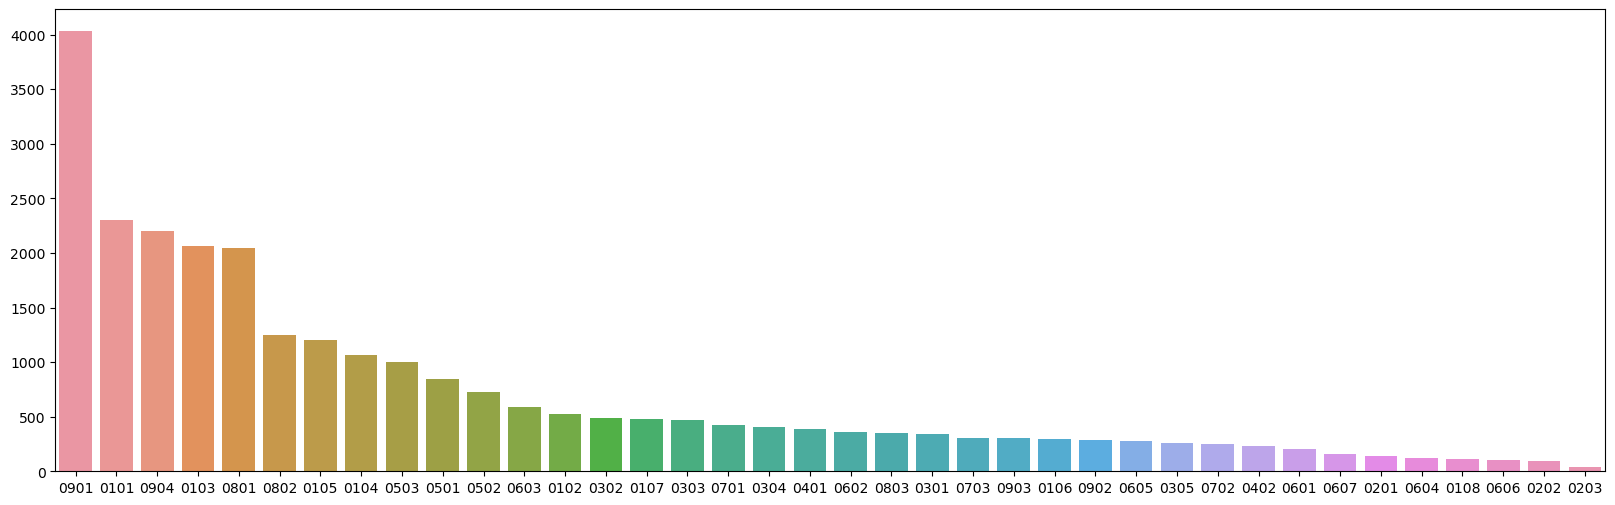

In [7]:
dog_counts = df['DogID'].value_counts()
plt.figure(figsize=(20, 6))
sns.barplot(x=dog_counts.index, y=dog_counts.values)
plt.show()

In [8]:
len(df['DogID'].unique())

38

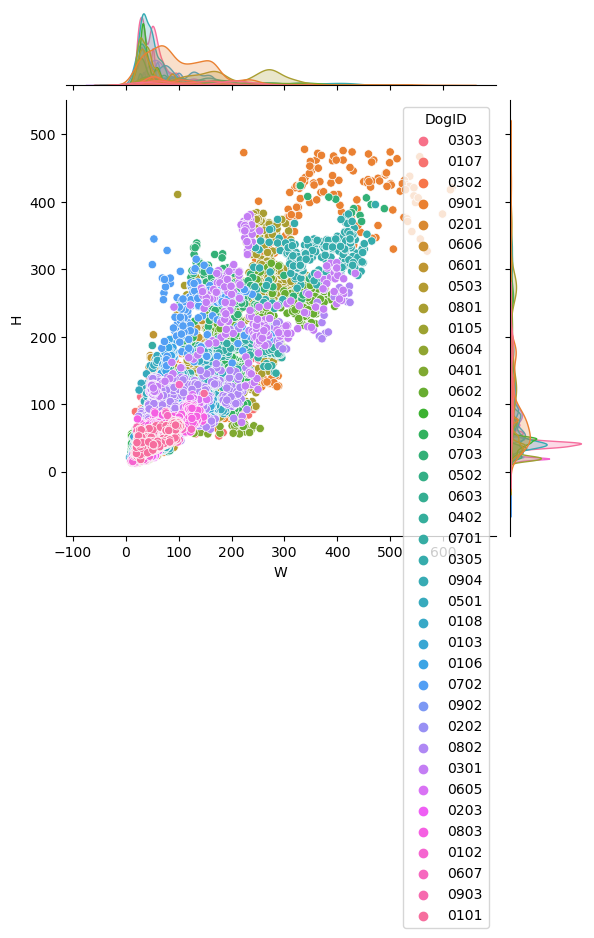

In [9]:
sns.jointplot(data=df, x="W", y="H", kind="scatter",hue = 'DogID')

# Data Prepaparation

In [10]:
!rm -r /kaggle/working/dataset

rm: cannot remove '/kaggle/working/dataset': No such file or directory


In [11]:
Tagert_sample = 200

In [12]:
def copy_images_to_folder(df, folder_path):
    for index, row in df.iterrows():
        dog_id = row['DogID']
        src_path = row['filepath']
        dst_dir = os.path.join(folder_path, dog_id)
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, os.path.basename(src_path))
        shutil.copy(src_path, dst_path)

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.RandomFlip('horizontal'), 
  tf.keras.layers.RandomRotation(0.1), 
  tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="reflect"), 
  tf.keras.layers.RandomContrast(factor=0.2),
  tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)), 
])


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

def augment_small_classes(small_df, baseDir, num_images_needed=Tagert_sample):
    augmented_df = pd.DataFrame(columns=small_df.columns)
    
    for dog_id in small_df['DogID'].unique():
        dog_df = small_df[small_df['DogID'] == dog_id]
        dog_df_count = len(dog_df)
        
        path_img = os.path.join(baseDir, dog_id)
        os.makedirs(path_img, exist_ok=True)
        
        test_filenames = dog_df['filepath'].tolist()
        df_test = pd.DataFrame({'filename': test_filenames})
        
        test_generator = ImageDataGenerator().flow_from_dataframe(df_test, 
                                                x_col='filename',
                                                class_mode=None,
                                                target_size=(224, 224),
                                                batch_size=len(test_filenames),
                                                shuffle=False)
        
        k = 0
        while len(os.listdir(path_img)) < num_images_needed:
            x = test_generator.next()
            x_augmented_image = data_augmentation(x)
            
            for i, j in enumerate(x_augmented_image):
                if len(os.listdir(path_img)) >= num_images_needed:
                    break

                dest_path = os.path.join(path_img, f'datagen-{k}.jpg')
                tf.keras.utils.save_img(dest_path, j)
                
                new_row = dog_df.iloc[i].copy()
                new_row['filepath'] = dest_path
                augmented_df = augmented_df.append(new_row, ignore_index=True)
                
                k += 1

    return augmented_df


In [15]:
def get_largest_n_images(df, n=Tagert_sample):
    result_df = pd.DataFrame()
    for dog_id in df['DogID'].unique():
        dog_df = df[df['DogID'] == dog_id]
        largest_images = dog_df.nlargest(n, 'W' if dog_df['W'].max() >= dog_df['H'].max() else 'H')
        result_df = result_df.append(largest_images)
    return result_df

In [16]:
largest_images_df = get_largest_n_images(df, Tagert_sample)

In [17]:
baseDir = '/kaggle/working/dataset'
os.makedirs(baseDir, exist_ok=True)

In [18]:
large_classes = largest_images_df['DogID'].value_counts().index
large_df = largest_images_df[largest_images_df['DogID'].isin(large_classes)]
copy_images_to_folder(large_df, baseDir)

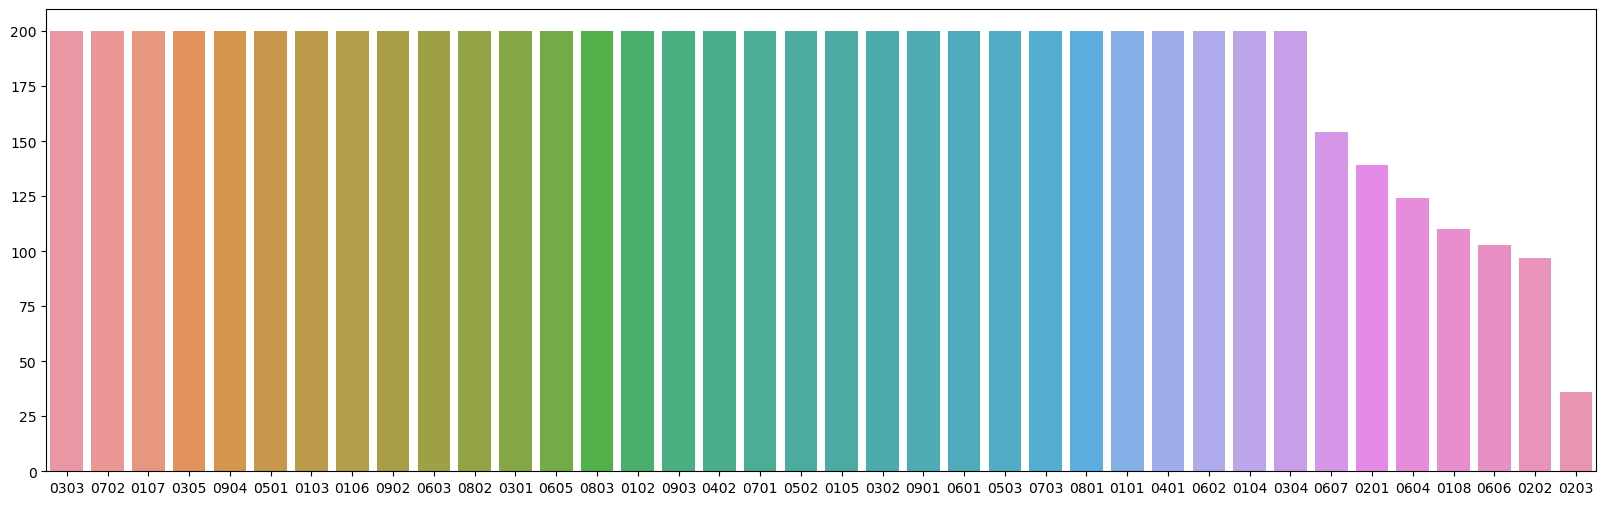

In [19]:
dog_counts = largest_images_df['DogID'].value_counts()
plt.figure(figsize=(20, 6))
sns.barplot(x=dog_counts.index, y=dog_counts.values)
plt.show()

In [20]:
all_classes = df['DogID'].value_counts()
small_classes = all_classes[all_classes < Tagert_sample].index
small_df = largest_images_df[largest_images_df['DogID'].isin(small_classes)]

In [21]:
print("Small classes:", small_classes)
print("Large classes:", large_classes)

Small classes: Index(['0607', '0201', '0604', '0108', '0606', '0202', '0203'], dtype='object')
Large classes: Index(['0303', '0702', '0107', '0305', '0904', '0501', '0103', '0106', '0902',
       '0603', '0802', '0301', '0605', '0803', '0102', '0903', '0402', '0701',
       '0502', '0105', '0302', '0901', '0601', '0503', '0703', '0801', '0101',
       '0401', '0602', '0104', '0304', '0607', '0201', '0604', '0108', '0606',
       '0202', '0203'],
      dtype='object')


In [22]:
new_small_df = augment_small_classes(small_df, baseDir)

Found 139 validated image filenames.
Found 103 validated image filenames.
Found 124 validated image filenames.
Found 110 validated image filenames.
Found 97 validated image filenames.
Found 36 validated image filenames.
Found 154 validated image filenames.


In [23]:
final_df = pd.concat([large_df, new_small_df], ignore_index=True)


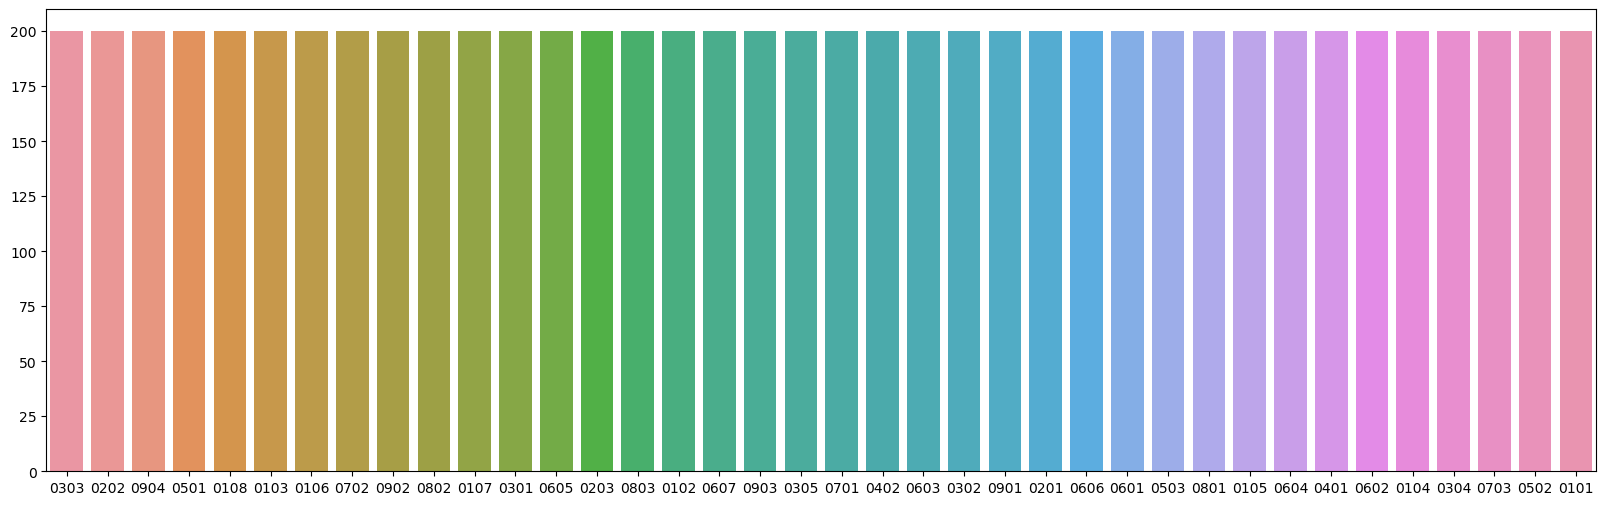

In [24]:
dog_counts = final_df['DogID'].value_counts()
plt.figure(figsize=(20, 6))
sns.barplot(x=dog_counts.index, y=dog_counts.values)
plt.show()

In [25]:
final_df

filepath    W    H DogID
0     /kaggle/input/datasetv2/train/DogID.0303/MVI_0...  278  187  0303
1     /kaggle/input/datasetv2/train/DogID.0303/MVI_0...  276  183  0303
2     /kaggle/input/datasetv2/train/DogID.0303/MVI_0...  268  186  0303
3     /kaggle/input/datasetv2/train/DogID.0303/MVI_0...  268  183  0303
4     /kaggle/input/datasetv2/train/DogID.0303/MVI_0...  267  165  0303
...                                                 ...  ...  ...   ...
7595        /kaggle/working/dataset/0607/datagen-41.jpg   87   71  0607
7596        /kaggle/working/dataset/0607/datagen-42.jpg   88   71  0607
7597        /kaggle/working/dataset/0607/datagen-43.jpg   92   71  0607
7598        /kaggle/working/dataset/0607/datagen-44.jpg   96   71  0607
7599        /kaggle/working/dataset/0607/datagen-45.jpg   94   71  0607

[7600 rows x 4 columns]

# Model

In [26]:
train_df, val_df = train_test_split(final_df, test_size=0.2, random_state=123, stratify=final_df['DogID'])

In [27]:
from tensorflow.keras.utils import plot_model

In [28]:
embedding_model = create_embedding_model()

219055592/219055592 [==============================] - 10s 0us/step


In [29]:
print(f'This is the number of trainable weights {len(embedding_model.trainable_weights)}')

This is the number of trainable weights 502


In [30]:
# Freeze all layers initially
for layer in embedding_model.layers:
    layer.trainable = False

# Find the index of the first layer of the last Inception-C module
for i, layer in enumerate(embedding_model.layers):
    if layer.name == 'block8_1_conv':
        block8_start_index = i
        break

# Unfreeze the Block8 (last Inception-C module) and dense layers
for layer in embedding_model.layers[block8_start_index:]:
    layer.trainable = True


In [31]:
print(f'This is the number of trainable weights after freeze some layers {len(embedding_model.trainable_weights)}')

This is the number of trainable weights 108


In [32]:
siamese_model = create_siamese_model(embedding_model)
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                          

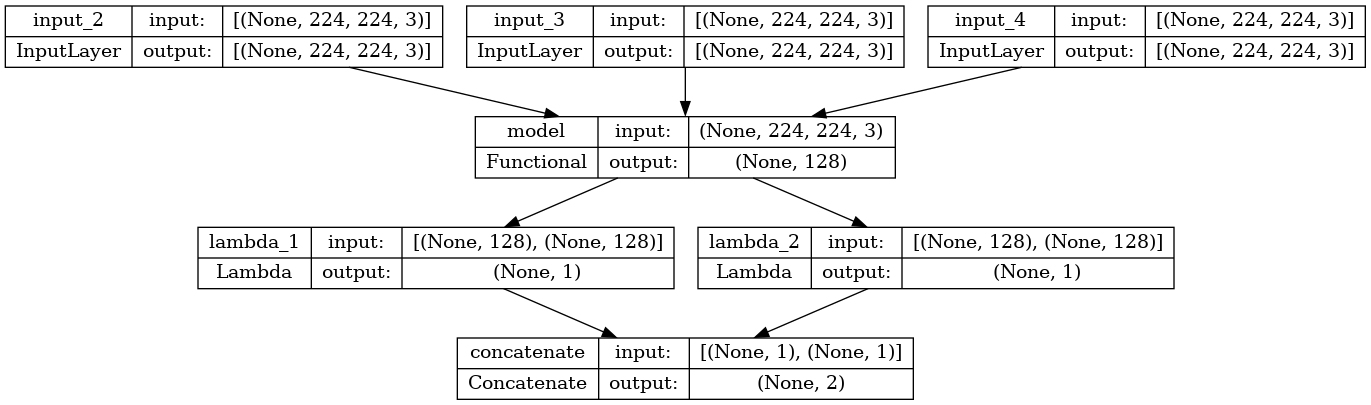

In [33]:
plot_model(siamese_model, show_shapes=True, show_layer_names=True)

In [34]:
# Instantiate the data generators
train_gen = data_generator(train_df, BATCH_SIZE)
val_gen = data_generator(val_df, BATCH_SIZE)

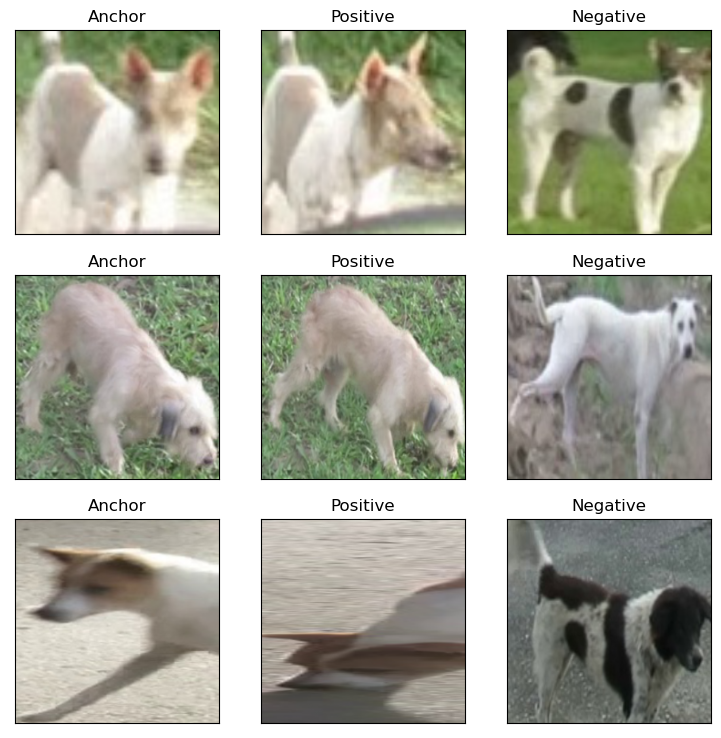

In [35]:
def visualize(anchor, positive, negative, anchor_labels, positive_labels, negative_labels):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image, label):
        ax.imshow(image)
        ax.set_title(label)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i], anchor_labels[i])
        show(axs[i, 1], positive[i], positive_labels[i])
        show(axs[i, 2], negative[i], negative_labels[i])

# Get a batch of data from the data generator
input_data, _ = next(train_gen)
anchor_batch, positive_batch, negative_batch = input_data

# Get the labels for anchor, positive, and negative images
anchor_labels = ["Anchor"] * 3
positive_labels = ["Positive"] * 3
negative_labels = ["Negative"] * 3

# Visualize the anchor, positive, and negative images with their labels
visualize(anchor_batch, positive_batch, negative_batch, anchor_labels, positive_labels, negative_labels)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

# Define your early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Siamese model with the learning rate scheduler and early stopping
history = siamese_model.fit(
    train_gen,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_df) // BATCH_SIZE,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
608/608 [==============================] - 512s 753ms/step - loss: 0.5695 - triplet_accuracy: 0.9247 - val_loss: 0.3487 - val_triplet_accuracy: 0.9658
Epoch 2/30
608/608 [==============================] - 465s 764ms/step - loss: 0.2929 - triplet_accuracy: 0.9683 - val_loss: 0.2012 - val_triplet_accuracy: 0.9816
Epoch 3/30
608/608 [==============================] - 514s 846ms/step - loss: 0.2104 - triplet_accuracy: 0.9783 - val_loss: 0.1528 - val_triplet_accuracy: 0.9895
Epoch 4/30
608/608 [==============================] - 516s 849ms/step - loss: 0.1591 - triplet_accuracy: 0.9875 - val_loss: 0.1107 - val_triplet_accuracy: 0.9868
Epoch 5/30
608/608 [==============================] - 519s 854ms/step - loss: 0.1397 - triplet_accuracy: 0.9913 - val_loss: 0.0985 - val_triplet_accuracy: 0.9947
Epoch 6/30
608/608 [==============================] - 469s 772ms/step - loss: 0.1170 - triplet_accuracy: 0.9934 - val_loss: 0.0735 - val_triplet_accuracy: 0.9967
Epoch 7/30
608/608 [========

In [37]:
print(history.history)

{'loss': [0.5695356130599976, 0.29287058115005493, 0.21039912104606628, 0.15914814174175262, 0.13968056440353394, 0.11699208617210388, 0.09908857941627502, 0.08638927340507507, 0.07724512368440628, 0.07018855214118958, 0.06322122365236282, 0.05886957421898842, 0.05095876008272171, 0.05026033893227577, 0.0452163964509964, 0.047636378556489944, 0.03901546448469162, 0.04027700796723366, 0.03672143444418907, 0.036319799721241, 0.03233511745929718, 0.0303089190274477, 0.027770107612013817, 0.02719132974743843, 0.026036804541945457, 0.024494512006640434, 0.022822462022304535, 0.02523224987089634, 0.022611329331994057, 0.023027580231428146], 'triplet_accuracy': [0.9246695637702942, 0.9682561755180359, 0.9782893657684326, 0.9875002503395081, 0.9912828207015991, 0.9934208393096924, 0.9949012398719788, 0.9975327849388123, 0.9980263113975525, 0.9986842274665833, 0.9985198974609375, 0.9991776347160339, 0.9991777539253235, 0.9990131855010986, 0.9993420839309692, 0.9991776347160339, 0.99934208393096

In [38]:
def evaluation(history):
    loss = history['loss']
    val_loss = history['val_loss']
    acc = history['triplet_accuracy']
    val_acc = history['val_triplet_accuracy']
    
    epochs = np.arange(len(loss))
    fig = plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, '-o', label="triplet_loss")
    plt.plot(epochs, val_loss, '-o', label="val_triplet_loss")
    plt.xlabel("Number of epochs")
    plt.yticks(np.arange(0, 8, 1))
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, '-o', label="triplet_accuracy")
    plt.plot(epochs, val_acc, '-o', label="val_triplet_accuracy")
    plt.xlabel("Number of epochs")
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid()
    plt.legend()
    fig.savefig('/kaggle/working/eval.jpg', dpi=300)

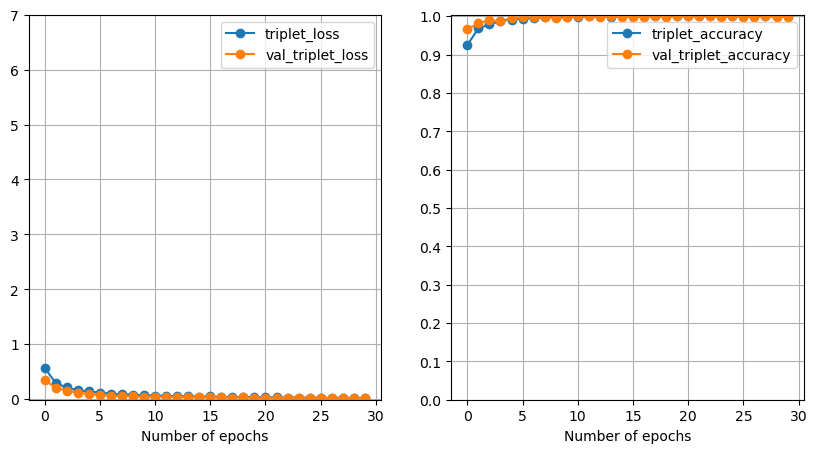

In [39]:
evaluation(history.history)

In [40]:
embedding_model.save_weights('/kaggle/working/weights_inceptionresnetv2.h5')
embedding_model.save('/kaggle/working/siamese_inceptionresnetv2.h5')


In [41]:
def load_image(image_path, img_size=IMG_SIZE):
    img = plt.imread(image_path)
    img = np.array(Image.fromarray(img).resize(img_size, resample=Image.BILINEAR))
    return img / 255.0

def load_images(filepaths, img_size=IMG_SIZE):
    images = [load_image(fp, img_size=img_size) for fp in filepaths]  # Pass img_size parameter here
    return np.stack(images)

def get_all_embeddings_batched(filepaths, model, batch_size=32):
    num_images = len(filepaths)
    all_embeddings = []

    for start_idx in range(0, num_images, batch_size):
        end_idx = start_idx + batch_size
        batch_filepaths = filepaths[start_idx:end_idx]
        batch_images = load_images(batch_filepaths)
        batch_embeddings = model.predict(batch_images, verbose=0)
        all_embeddings.extend(batch_embeddings)

    return np.array(all_embeddings)

In [42]:
train_filepaths = df['filepath'].tolist()
test_filepaths = df_test['filepath'].tolist()

In [43]:
train_embeddings = get_all_embeddings_batched(train_filepaths, embedding_model)
test_embeddings = get_all_embeddings_batched(test_filepaths, embedding_model)

In [44]:
from sklearn.manifold import TSNE
import time

n_components = 2
verbose = 1
perplexity = 30
n_iter = 1000
metric = 'euclidean'

time_start = time.time()
tsne_results = TSNE(n_components=n_components,
                    verbose=verbose,
                    perplexity=perplexity,
                    n_iter=n_iter,
                    metric=metric).fit_transform(train_embeddings) #Here

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 26737 samples in 0.004s...
[t-SNE] Computed neighbors for 26737 samples in 19.687s...
[t-SNE] Computed conditional probabilities for sample 1000 / 26737
[t-SNE] Computed conditional probabilities for sample 2000 / 26737
[t-SNE] Computed conditional probabilities for sample 3000 / 26737
[t-SNE] Computed conditional probabilities for sample 4000 / 26737
[t-SNE] Computed conditional probabilities for sample 5000 / 26737
[t-SNE] Computed conditional probabilities for sample 6000 / 26737
[t-SNE] Computed conditional probabilities for sample 7000 / 26737
[t-SNE] Computed conditional probabilities for sample 8000 / 26737
[t-SNE] Computed conditional probabilities for sample 9000 / 26737
[t-SNE] Computed conditional probabilities for sample 10000 / 26737
[t-SNE] Computed conditional probabilities for sample 11000 / 26737
[t-SNE] Computed conditional probabilities for sample 12000 / 26737
[t-SNE] Computed conditional probabilities for sa

In [45]:
def extract_image_id(row):
    filepath = row['filepath']
    img_class = os.path.basename(os.path.dirname(filepath)).split('.')[-1]
    return img_class

In [46]:
df_test['True_DogID'] = df_test.apply(extract_image_id, axis=1)
train_filepaths = df['filepath'].tolist()
train_dog_ids = df['DogID'].tolist()
test_filepaths = df_test['filepath'].tolist()
test_dog_ids = df_test['True_DogID'].tolist()

38


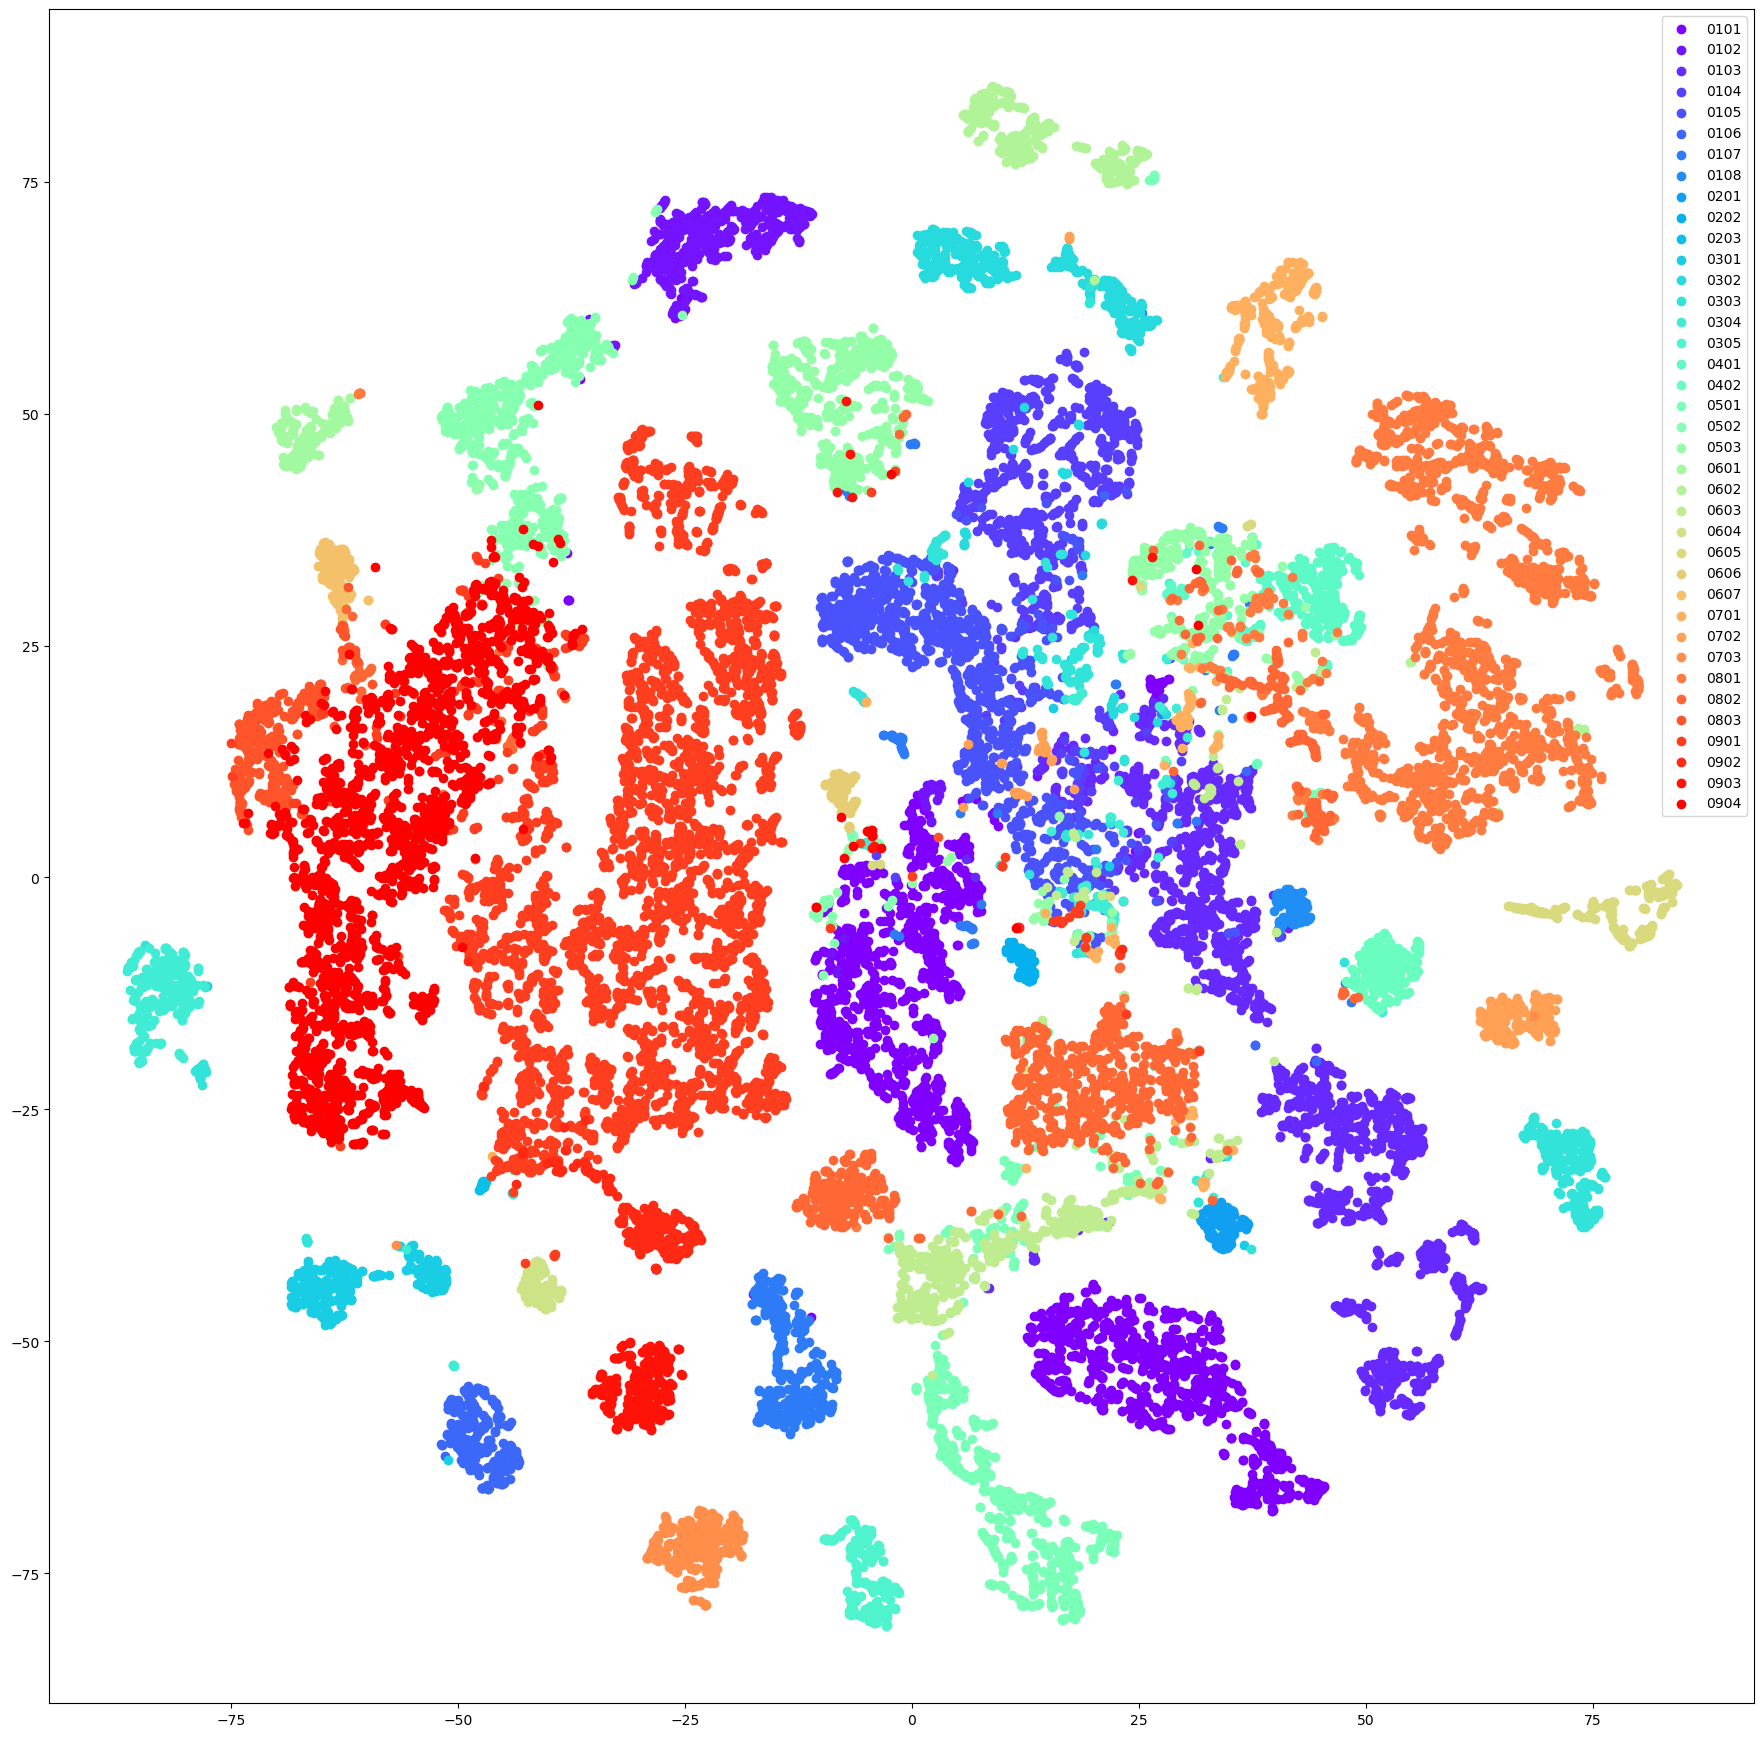

In [47]:
# Create a dictionary to map labels to colors
unique_labels = np.unique(train_dog_ids)
print(len(unique_labels))
# Create a dictionary to map labels to colors
unique_labels = np.unique(train_dog_ids)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
label_to_color = dict(zip(unique_labels, colors))

# Plot the t-SNE points with colors based on their labels
fig, ax = plt.subplots(figsize=(22, 22))
for label, color in label_to_color.items():
    indices = [i for i, l in enumerate(train_dog_ids) if l == label]
    ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], c=[color], label=label)

# Add a legend
ax.legend()
plt.show()

In [48]:
fig.savefig('/kaggle/working/train_tsne.jpg', dpi=300)

In [49]:
from sklearn.manifold import TSNE
import time

n_components = 2
verbose = 1
perplexity = 30
n_iter = 1000
metric = 'euclidean'

time_start = time.time()
tsne_results = TSNE(n_components=n_components,
                    verbose=verbose,
                    perplexity=perplexity,
                    n_iter=n_iter,
                    metric=metric).fit_transform(test_embeddings) #Here

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2897 samples in 0.001s...
[t-SNE] Computed neighbors for 2897 samples in 0.238s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2897
[t-SNE] Computed conditional probabilities for sample 2000 / 2897
[t-SNE] Computed conditional probabilities for sample 2897 / 2897
[t-SNE] Mean sigma: 0.105571
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.642929
[t-SNE] KL divergence after 1000 iterations: 0.664169
t-SNE done! Time elapsed: 15.990767240524292 seconds


8


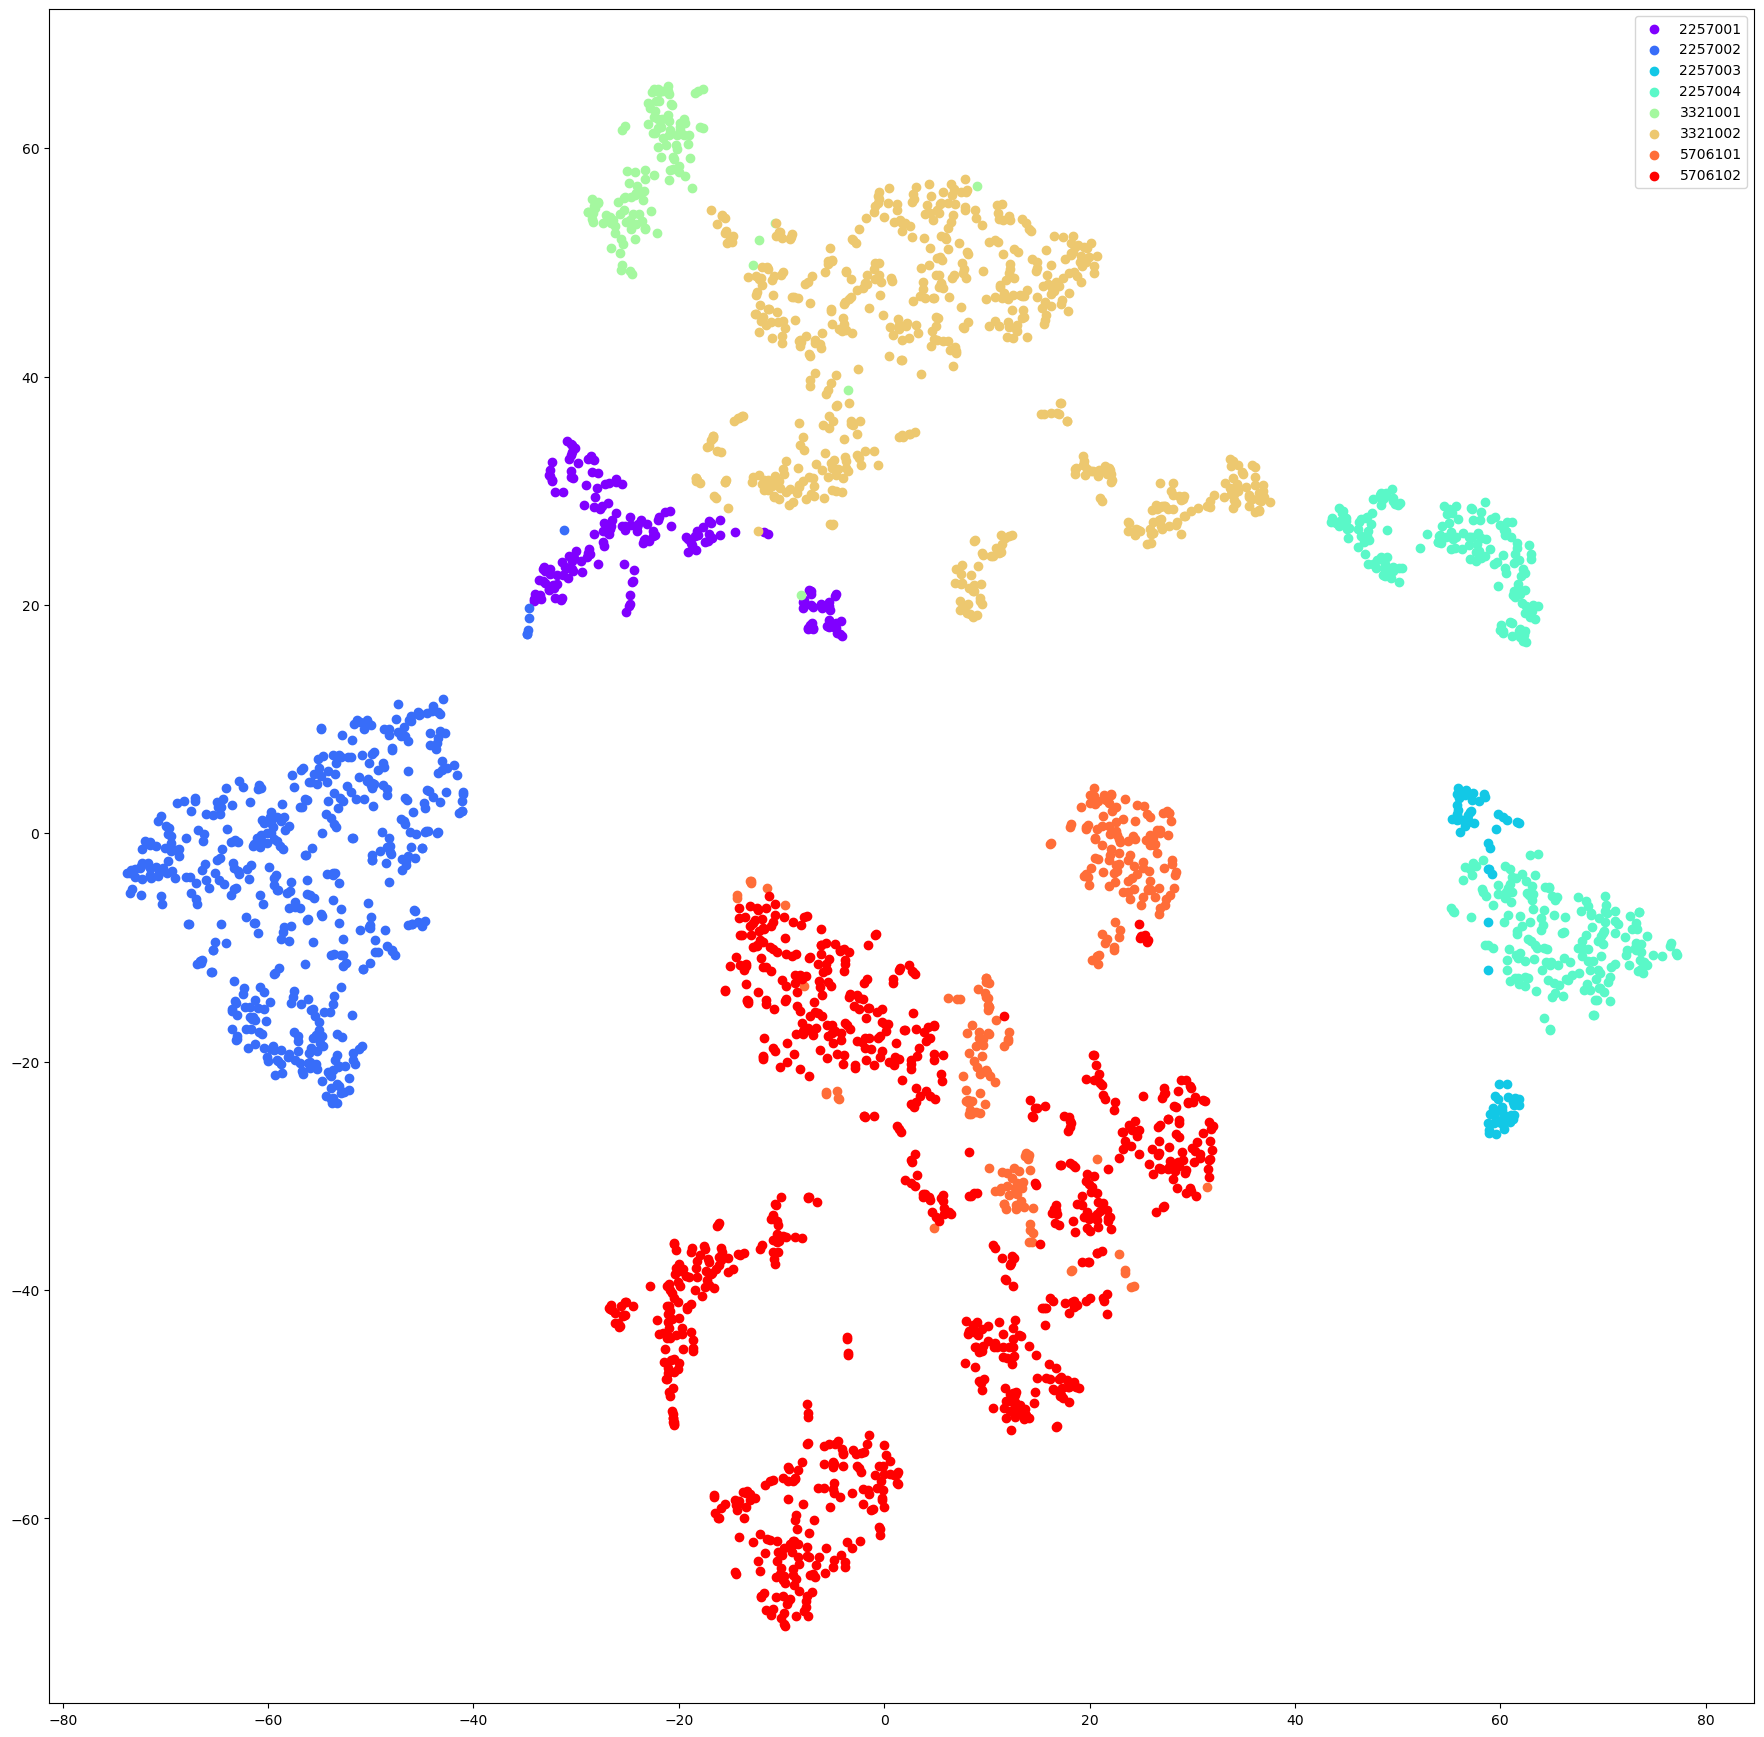

In [50]:
# Create a dictionary to map labels to colors
unique_labels = np.unique(test_dog_ids)
print(len(unique_labels))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
label_to_color = dict(zip(unique_labels, colors))

# Plot the t-SNE points with colors based on their labels
fig, ax = plt.subplots(figsize=(22, 22))
for label, color in label_to_color.items():
    indices = [i for i, l in enumerate(test_dog_ids) if l == label]
    ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], c=[color], label=label)

# Add a legend
ax.legend()
plt.show()

In [51]:
fig.savefig('/kaggle/working/test_tsne.jpg', dpi=300)

In [52]:
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

def visualize_closest_images_cosine_similarity(query_embeddings, test_embeddings, query_filepaths, test_filepaths, n_closest):
    similarities = cosine_similarity(query_embeddings, test_embeddings)
    fig, axes = plt.subplots(len(query_filepaths), n_closest + 1, figsize=(3 * (n_closest + 1), 3 * len(query_filepaths)))

    for i, query_filepath in enumerate(query_filepaths):
        query_image = Image.open(query_filepath)
        query_image.thumbnail((100, 100), Image.ANTIALIAS)
        axes[i, 0].imshow(query_image)
        axes[i, 0].set_title("Query Image")
        axes[i, 0].axis("off")

        closest_indices = np.argpartition(similarities[i], -n_closest)[-n_closest:]
        sorted_closest_indices = closest_indices[np.argsort(-similarities[i, closest_indices])]

        for j, closest_index in enumerate(sorted_closest_indices):
            test_image = Image.open(test_filepaths[closest_index])
            test_image.thumbnail((100, 100), Image.ANTIALIAS)
            axes[i, j + 1].imshow(test_image)
            axes[i, j + 1].set_title(f"Closest {j + 1}\nSimilarity: {similarities[i, closest_index]:.2f}")
            axes[i, j + 1].axis("off")

    plt.tight_layout()
    plt.show()


In [53]:
query_filepaths = [path for path in glob.glob('/kaggle/input/datasetv2/query/*.jpg', recursive = True)]
print(f"Total query images: {len(query_filepaths)}")

Total query images: 8


In [54]:
query_embeddings = get_all_embeddings_batched(query_filepaths, embedding_model)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.


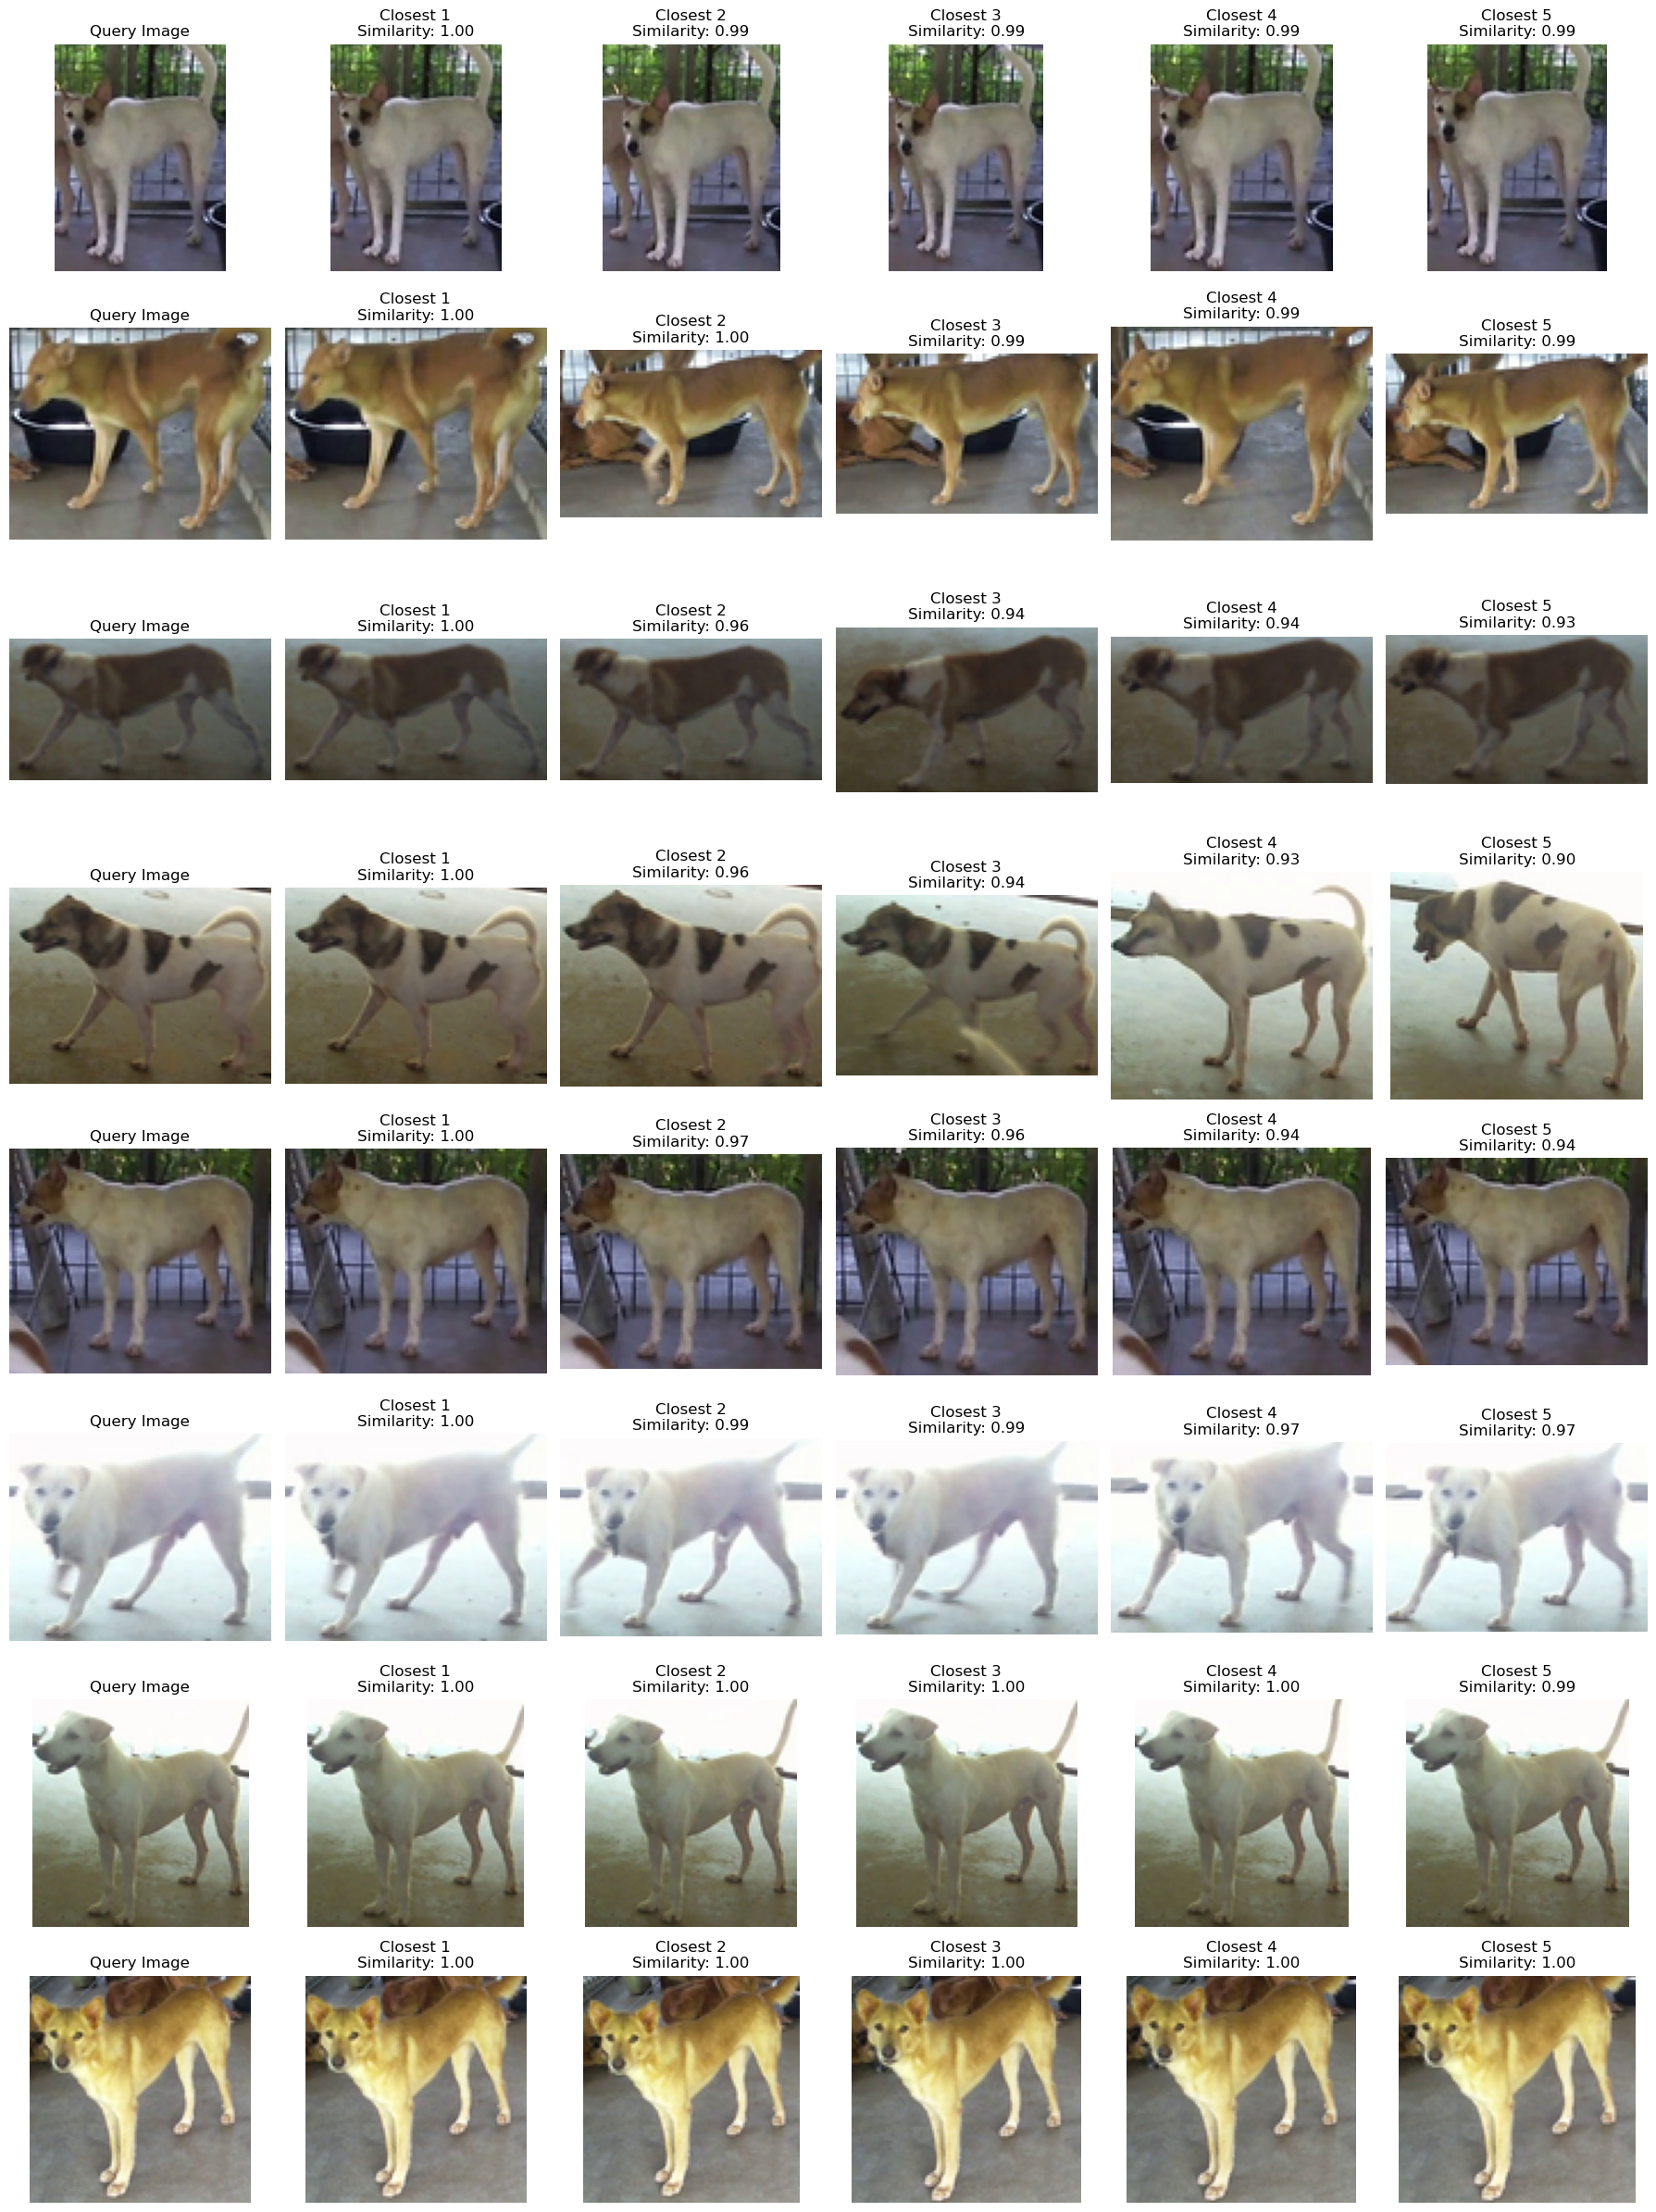

In [55]:
n_closest = 5
visualize_closest_images_cosine_similarity(query_embeddings, test_embeddings, query_filepaths, test_filepaths, n_closest)


In [56]:
df_test

filepath True_DogID
0     /kaggle/input/datasetv2/unseen/2257003/WIN_202...    2257003
1     /kaggle/input/datasetv2/unseen/2257003/WIN_202...    2257003
2     /kaggle/input/datasetv2/unseen/2257003/WIN_202...    2257003
3     /kaggle/input/datasetv2/unseen/2257003/WIN_202...    2257003
4     /kaggle/input/datasetv2/unseen/2257003/WIN_202...    2257003
...                                                 ...        ...
2892  /kaggle/input/datasetv2/unseen/3321002/WIN_202...    3321002
2893  /kaggle/input/datasetv2/unseen/3321002/WIN_202...    3321002
2894  /kaggle/input/datasetv2/unseen/3321002/WIN_202...    3321002
2895  /kaggle/input/datasetv2/unseen/3321002/WIN_202...    3321002
2896  /kaggle/input/datasetv2/unseen/3321002/WIN_202...    3321002

[2897 rows x 2 columns]

In [57]:
test_filepaths = df_test['filepath'].tolist()
true_labels = df_test['True_DogID'].tolist()

similarity_matrix = cosine_similarity(test_embeddings)

In [58]:
from sklearn.metrics import roc_curve, auc, accuracy_score

def get_binary_labels(true_labels):
    num_samples = len(true_labels)
    binary_labels = np.zeros((num_samples, num_samples), dtype=bool)
    for i in range(num_samples):
        for j in range(num_samples):
            binary_labels[i, j] = true_labels[i] == true_labels[j]
    return binary_labels

binary_labels = get_binary_labels(true_labels)
binary_labels_flat = binary_labels.flatten()

thresholds = np.linspace(0, 1, num=200)
best_threshold = 0
best_acc = 0

for threshold in thresholds:
    pred_labels_flat = similarity_matrix.flatten() > threshold
    acc = accuracy_score(binary_labels_flat, pred_labels_flat)
    if acc > best_acc:
        best_acc = acc
        best_threshold = threshold

print("Best threshold:", best_threshold)
print("Best accuracy:", best_acc)


Best threshold: 0.7035175879396985
Best accuracy: 0.8977245335747204


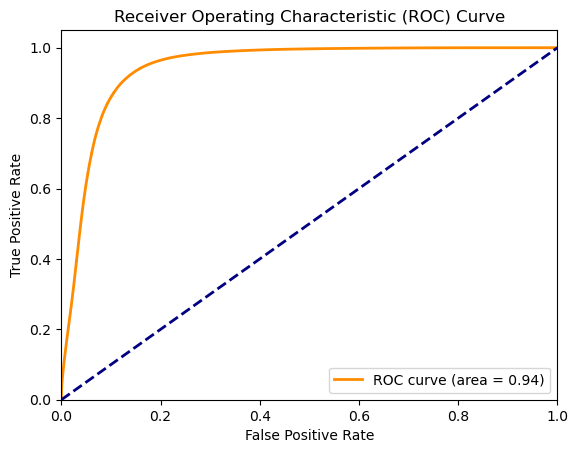

In [59]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(binary_labels_flat, similarity_matrix.flatten())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [60]:
fig.savefig('/kaggle/working/roc.jpg', dpi=300)

In [61]:
def average_precision(ranked_labels, true_label, rank):
    correct_label_count = 0
    ap_sum = 0
    for i, label in enumerate(ranked_labels[:rank]):
        if label == true_label:
            correct_label_count += 1
            ap_sum += correct_label_count / (i + 1)
    return ap_sum / correct_label_count if correct_label_count > 0 else 0

def mean_average_precision(similarity_matrix, true_labels, ranks):
    num_queries = len(true_labels)
    map_values = []
    
    for rank in ranks:
        ap_values = []
        for query_idx in range(num_queries):
            query_similarities = similarity_matrix[query_idx]
            sorted_indices = np.argsort(-query_similarities)  # Sort in descending order
            ranked_labels = [true_labels[i] for i in sorted_indices]
            ap = average_precision(ranked_labels, true_labels[query_idx], rank)
            ap_values.append(ap)
        map_values.append(np.mean(ap_values))
    return map_values

ranks = [1, 5, 10, 50, 1000]
map_values = mean_average_precision(similarity_matrix, df_test['True_DogID'], ranks)

for rank, map_value in zip(ranks, map_values):
    print(f"MAP@{rank}: {map_value:.4f}")

MAP@1: 1.0000
MAP@5: 0.9979
MAP@10: 0.9935
MAP@50: 0.9664
MAP@1000: 0.8033


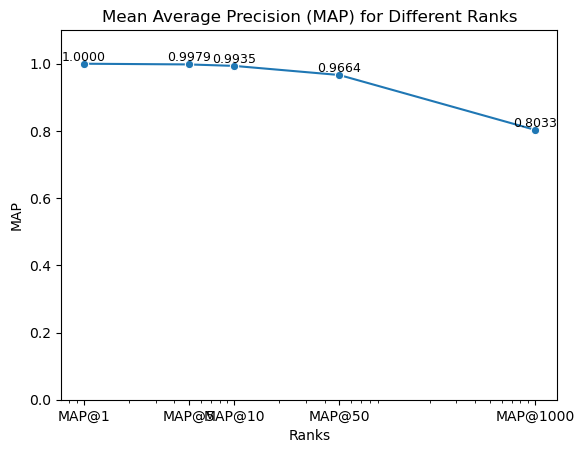

In [62]:
data = pd.DataFrame({'Ranks': ranks, 'MAP': map_values})
plt.figure()
sns.lineplot(data=data, x='Ranks', y='MAP', marker='o')

# Set the y-axis limits to be between 0 and 1
plt.ylim(0, 1.1)

# Set the x-axis to logarithmic scale
plt.xscale('log')

# Customize the x-axis ticks and labels
plt.xticks(ranks, [f'MAP@{rank}' for rank in ranks])

# Add the title
plt.title('Mean Average Precision (MAP) for Different Ranks')

# Add the MAP values as labels on the plot
for i, value in enumerate(map_values):
    plt.text(ranks[i], value + 0.01, f"{value:.4f}", ha='center', fontsize=9)

plt.savefig('/kaggle/working/map.jpg')

# How to load_savedmodel

In [63]:
from tensorflow.keras.models import load_model
new_model = load_model('/kaggle/working/siamese_inceptionresnetv2.h5', compile=False)
new_model.load_weights('/kaggle/working/weights_inceptionresnetv2.h5')